# **Introduction**
Hello, 
In this notebook you will find a simple approach to tackle the famous Titanic disaster machine learning. It will include a full pipeline for data cleaning, feature engineering, modeling and paramaters tunning. I didn't focus on EDA because my main goal was to focus on feature engineering and classification task.

# **Table of contents:** 

1. Loading data and some EDA

2. Data Processing

    2.1 Data cleaning: Dealing with null values

    2.2 Feature engineering and encoding

    2.3 Data Processing Pipeline

3. Modeling

    3.1 Evaluating models and making a choice

    3.2 Hyper paramater tuning and combining models

4. Submitting results

In [1]:
# setting up the libraries that we will need 
import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

## **1. Loading data and some EDA:**

In [2]:
# loading the data
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
sub = pd.read_csv("../input/titanic/gender_submission.csv")

In [3]:
#data exploration
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.select_dtypes(include = ['object']).describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Harris, Mr. Walter",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


* Training set have missing values in Age, Cabin and Embarked columns
* Test set have missing values in Age, Cabin and Fare columns

In [7]:
print('Only {0:.0f}% of passengers have survived'.format(train["Survived"].value_counts(1)[1]*100))

Only 38% of passengers have survived


In [8]:
train_copy = train.copy()
test_copy = test.copy()

In [9]:
def corr(x):
    corr_matrix = x.corr()
    c= corr_matrix["Survived"].sort_values(ascending=False)
    print(c)
corr(train_copy)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


### Parch and SibSp attribute

In [10]:
print('{0:.2f}% of Parch values are 0'.format(train.Parch.value_counts(1)[0]*100))
print('{0:.2f}% of SibSp vales are 0'.format(train.SibSp.value_counts(1)[0]*100))

76.09% of Parch values are 0
68.24% of SibSp vales are 0


Most of Parch and SibSp values are 0 and they are not highly correlated with the target. On their own they don't give an important information. However, if we combine them we can create a new attribute called "Family Size" with 3 catergories: Small, Medium and Large. We can also add Alone category if the passenger has no family onboard the ship.

### Cabin Attribute


In [11]:
print('{0:.0f}% of Cabin attribute in values are missing in training data'.format(train['Cabin'].isnull().value_counts(1)[1]*100))
print('{0:.0f}% of Cabin attribute in values are missing in test data'.format(test['Cabin'].isnull().value_counts(1)[1]*100))

77% of Cabin attribute in values are missing in training data
78% of Cabin attribute in values are missing in test data


* Its true that most of Cabin attribute are missing values but we can't drop this feature because some of the cabins have more survival rate than others, for example these who are close to surface.
* After some research, tt turns out to be that the first letter of the Cabin values are the decks in which the cabins are located. So we will change the cabin attribute with a deck attribute and explore further this new feature


In [12]:
train_copy["deck"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train_copy['Cabin'] ])
test_copy["deck"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in test_copy['Cabin'] ])

In [13]:
train_copy.groupby(['deck','Pclass'])['deck'].count()

deck  Pclass
A     1          15
B     1          47
C     1          59
D     1          29
      2           4
E     1          25
      2           4
      3           3
F     2           8
      3           5
G     3           4
T     1           1
X     1          40
      2         168
      3         479
Name: deck, dtype: int64

In [14]:
test_copy.groupby(['deck','Pclass'])['deck'].count()

deck  Pclass
A     1           7
B     1          18
C     1          35
D     1          11
      2           2
E     1           9
F     2           5
      3           3
G     3           1
X     1          27
      2          86
      3         214
Name: deck, dtype: int64

If you watched the movie then you know that decks were separated and some of them were meant to be used by 1 passenger class. However some of the decks were used by multiple class:
* A, B and C decks: only for 1st class passengers
* D and E: for all classes
* F and G decks: for both 2nd and 3rd class passengers
* Passengers labeled as X are the missing values in Cabin feature. I don't think it is possible to find those passengers' real Deck.

### Age

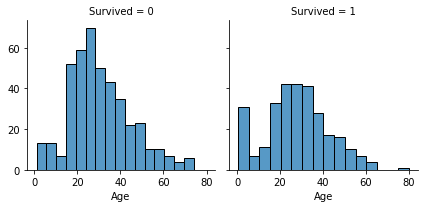

In [15]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot, "Age")

* Age distribution seems to be a gaussian distribution. We can notice that Age distribution are not the same in the survived and not survived subpopulation: Those who are between 60 and 80 are less likely to survive, and childrens and young passengers have higher chances of survival. 
* Transforming the age feature into categories seems better than using the age of each person because some there is some age categories that have high or less chance of surviving.

### Fare and Embarked

In [16]:
f=test.Fare.isnull().value_counts()[1]
e=train.Embarked.isnull().value_counts()[1]
print('Only {0} value of Fare attribute is missing in test and only {1} values of Embarked attribute are missing in train'.format(f,e))

Only 1 value of Fare attribute is missing in test and only 2 values of Embarked attribute are missing in train


In [17]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


* The passengers that has a missing value for fare is from class 3 and has 0 family members with him.

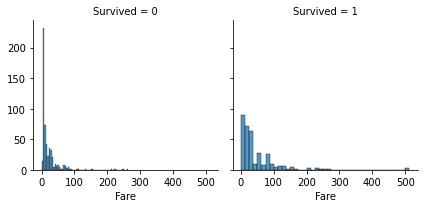

In [18]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.histplot, "Fare")

* Fare distribution is very skewed and might result in badbehaviour in our model. Transforming it into log seems like a good solution.

### Ticket

In [19]:
print('There is {0} unique values of Ticket attribute'.format(len(train.Ticket.unique())))

There is 681 unique values of Ticket attribute


* There is a large number of unique Tickets to analyse so we can create a ticket_freq attribute instead of Tickets.
* Many passengers travelled along with groups. Those groups consist of friends, nannies, maids and etc. They weren't counted as family, but they used the same ticket.

### Name

* For the name attribute we can extract the title and analyse it better. We can extract family names also but that would take too much time so I am gonna stick to the title only

In [20]:
train_copy['Title'] = train_copy['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]

In [21]:
train_copy.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
the Countess      1
Don               1
Ms                1
Lady              1
Jonkheer          1
Sir               1
Mme               1
Capt              1
Name: Title, dtype: int64

* We can notice that we have 4 major categories and that all the others can be of these 4. In the feature engineering section we will create 4 categories only for these attribute

## **2. Data Processing**
### 2.1 Data Cleaning: Dealing with missing value
We did notice in the previous section that some of the attributes are missing 1 or 2 values while other have more than 70% of missing values. So here we will deal with this missing data using diffirent approaches for each attribute.
* One of the common approaches for filling missing numerical values is using the media. However, using the age might be a little bit tricky because the classes of passengers have different age ranges. So we will replace the missing values with the media age for each class, for both male and female passengers.
* For the fare, we have only 1 missing value. We will fill it with the median 3rd class passangers that have no family with them
* For Embarked we will use the most Frequent which is S
* For the Cabin attribute we will deal with it in the feature engineering section because we are going to create a new attribute

In [22]:
class Imputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.med_fare_ = X.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
        self.most_freq_embarked = X.Embarked.value_counts().index[0]
        return self
    def transform(self, X, y=None):
        #replacing missing values of Age with median Age for each class. 1 value for each Sex.
        X.Age = X.groupby(['Sex', 'Pclass'])['Age'].apply(lambda z: z.fillna(z.median()))
        # 1 only missing value for Fare. A Man in the third class with no family
        X.Fare = X.Fare.fillna(self.med_fare_)
        # filling Embarked with the most frequent 
        X.Embarked = X.Embarked.fillna(self.most_freq_embarked)
        
        return X
        
    

### 2.2 Feature Engineering:
#### 2.2.1 Creating new features
In this section we will transform existing attribute and create new ones:
* First we will combine the Parch and SibSp to create a Relative on board feature.
* Using the Relative On board feature we will create a family attribute which consists of: 
 - Alone if the passenger has no relatives on board
 - Small if he have 1 or 2 family members on board
 - Medium if he have 3, 4 or 5 family members
 - Large if he has more than 6
* Using the cabin feature we will create a deack attribute by extracting the first letter of the cabin name for each passenger.
* we will transform the Age from continuous data into and attribute with 8 categories.
* For Fare, Applying will reduce skewness distribution
* Replace ticket ID by ticket frequency
* Extract title attribute from Name and create IsMarried Attribute


In [23]:
class feature_engineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # combining Sibsp and Parch to create relative on board then creating the family attribute
        X["RelativesOnboard"] = X["SibSp"] + X["Parch"]
        X['Family'] = X['RelativesOnboard'].map({0: 'Alone', 1: 'Small', 2: 'Small', 3: 'Medium', 4: 'Medium', 5: 'Medium', 6: 'Large', 7: 'Large', 10: 'Large'})
        # extracting the first letter of each cabin to create deck attribute
        X["Deck"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in X['Cabin'] ])  
        # regrouping deck catergories
        X['Deck'] = X['Deck'].replace(['T', 'A', 'B', 'C'], 'ABC')
        X['Deck'] = X['Deck'].replace(['D', 'E'], 'DE')
        X['Deck'] = X['Deck'].replace(['F', 'G'], 'FG')
        # we will transform the Age from continuous data into and attribute with 14 category.
        X["Age"] = pd.cut(X["Age"],
                               bins=[0., 5.0, 15.0, 25.0, 30.0, 40.0,50.0,60.0, np.inf],
                               labels=[1, 2, 3, 4, 5,6,7,8])
        # For Fare, Applying will reduce skewness distribution
        X["Fare"] = X["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
        # Replace ticket ID by ticket frequency
        X['Ticket_Frequency'] = X.groupby('Ticket')['Ticket'].transform('count')
        # Extract title attribute from Name and create IsMarried Attribute
        X['Title'] = X['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
        X['Is_Married'] = 0
        X['Is_Married'].loc[X['Title'] == 'Mrs'] = 1
        X['Title'] = X['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
        X['Title'] = X['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
        return X

#### 2.2.2 Enconding
In this section we will label encode the following features:
* Age, Fare, Embarked, Sex, Title, Family, Title, RelativesOnboard, Deck.

And use OneHotEncoding on the folliwing featues:
* Pclass, Sex, Deck, Family, Title, Embarked

In [24]:
class encoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        #label encoding
        for i in ['Age', 'Fare', 'Embarked', 'Sex', 'Title', 'Family', 'Title', 'RelativesOnboard', 'Deck']:
            X[i] = self.le.fit_transform(X[i])
        #OneHotEncoding
        encoded_features = []
        for cat in ['Deck', 'Age','Pclass', 'Sex', 'Title','Embarked','Family','RelativesOnboard']:
            encoded_feat = self.ohe.fit_transform(X[cat].values.reshape(-1, 1)).toarray()
            n = X[cat].nunique()
            cols = ['{}_{}'.format(cat, n) for n in range(1, n + 1)]
            encoded_df = pd.DataFrame(encoded_feat, columns=cols)
            encoded_df.index = X.index
            encoded_features.append(encoded_df)
        X = pd.concat([X, *encoded_features[:8]], axis=1)
        return X

#### 2.3 Data processing pipeline

In [25]:
# This class is used after cleaning and feature engineering to drop unnecessary columns
class Columns_drop(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.drop(self.attribute_names, axis=1)

In [26]:
dropped_columns = [ 'RelativesOnboard','Age', 'Sex','Deck', 'Family', 'Embarked', 'PassengerId', 'Pclass', 'Name', 'Ticket','Cabin','Embarked']


In [27]:
processing_pipeline = Pipeline([
    ('Filling missing values', Imputer()),
    ('Feature Engineering', feature_engineering()),
    ('Encoding', encoding()),
    ('dropping useless columns', Columns_drop(dropped_columns) ),
    
])

In [28]:
X_train= train.copy()
X_test = test.copy()
X_train = processing_pipeline.fit_transform(X_train)
corr(X_train)
X_train = X_train.drop('Survived',axis=1 )
y_train = train['Survived']
X_test = processing_pipeline.fit_transform(test)


Survived              1.000000
Sex_1                 0.543351
Title_3               0.540769
Is_Married            0.339040
Fare                  0.333943
Pclass_1              0.285904
Family_4              0.238059
Deck_2                0.213430
Deck_1                0.202551
Embarked_1            0.168240
RelativesOnboard_2    0.163157
Age_1                 0.150304
RelativesOnboard_3    0.143869
RelativesOnboard_4    0.128347
Pclass_2              0.093349
Title_2               0.085221
Parch                 0.081629
Age_5                 0.068219
Deck_3                0.058617
Ticket_Frequency      0.038247
Age_2                 0.034183
Family_3              0.014687
Age_7                 0.009569
Embarked_2            0.003650
Age_4                 0.002193
Age_6                -0.000079
RelativesOnboard_7   -0.012134
Title_1              -0.031348
SibSp                -0.035322
RelativesOnboard_5   -0.049466
Age_8                -0.051224
RelativesOnboard_8   -0.064988
Relative

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## **3. Modeling**
#### 3.1 Evaluating models and making a choice
In this section we evaluate the performance of some well known models on the data and chose those who have a good accuracy. We will cross validation on 10 folds to meausure the performance on train data. 

In [29]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold


In [30]:
kfold = StratifiedKFold(n_splits=10)
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier())
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"Algorithm":["SVC","DecisionTree","RandomForest","GradientBoosting","ExtraTrees"],"CrossValMeans":cv_means,"CrossValerrors": cv_std})
cv_res

,Algorithm,CrossValMeans,CrossValerrors
0,SVC,0.682497,0.057079
1,DecisionTree,0.812609,0.024790
2,RandomForest,0.813720,0.041042
3,GradientBoosting,0.833945,0.044643
4,ExtraTrees,0.800262,0.028012


RandomForest and Gradient boosting are promissing models so we will continue with them.

#### 3.2 Hypter parameter tunning and combining models

In [31]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 3)]
# Number of features to consider at every split
max_features = [ 20 ,'auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
rf_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


In [32]:
# The number of boosting stages to perform
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = [ 20 ,'auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,  10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# The function to measure the quality of a split
# Create the random grid
gb_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,}


In [33]:
# Random forest Hyper parameter tuning
rf = RandomForestClassifier()

#fitting
Grid_s_rf = GridSearchCV(rf, param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = True)
Grid_s_rf.fit(X_train,y_train)
RFC_best = Grid_s_rf.best_estimator_

# Best score
Grid_s_rf.best_score_

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


0.8417852684144819

In [34]:
# Gradient boosting Hyper parameter tuning
gbc = GradientBoostingClassifier()

#fitting
Grid_s_gb = GridSearchCV(gbc,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)
Grid_s_gb.fit(X_train,y_train)
GBC_best = Grid_s_gb.best_estimator_

# Best score
Grid_s_gb.best_score_


Fitting 10 folds for each of 216 candidates, totalling 2160 fits


0.8272034956304619

For each model we have 216 candidates, fiited for 10 folds resulting in 2160 fils in total. we will chose the best 2 models and then combine them using VotingClassifier.

In [35]:
#Combining 2 models
votingC = VotingClassifier(estimators=[('rfc', RFC_best),('gbc',GBC_best)], voting='soft', n_jobs=-1)
votingC = votingC.fit(X_train, y_train)

## **4. Submitting results**


In [36]:
predictions = votingC.predict(X_test)
submission = pd.DataFrame({'PassengerId': test.PassengerId,
                           'Survived': predictions})
submission.to_csv('submission.csv', index = False)